In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks/Paper/EXP/'
expr_path = root_path + 'Benchmark/PTB/char-level/expRNN'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import_path = [root_path + subpath for subpath in ['sources/', 'sources/expRNN/']]
for path in import_path:
  sys.path.append(path)

In [ ]:
import sys
import argparse
sys.argv = ['']
parser = argparse.ArgumentParser(description='expRNN PTB-c Task (L=150)')
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--hidden_size', type=int, default=170)
parser.add_argument('--epochs', type=int, default=70)
parser.add_argument('--use_adam', type=bool, default=False)
parser.add_argument('--adam_lr', type=float, default=1e-3)
parser.add_argument('--rmsprop_lr', type=float, default=7e-4)
parser.add_argument('--rmsprop_constr_lr', type=float, default=7e-5)
parser.add_argument('--alpha', type=float, default=0.99)
parser.add_argument('--clip_norm', type=float, default=-1)
parser.add_argument("--permute", action="store_true", default = False)
parser.add_argument("-m", "--mode",
                    choices=["exprnn", "dtriv", "cayley", "lstm", "rnn"],
                    default="exprnn",
                    type=str)
parser.add_argument('--K', type=str, default="100", help='The K parameter in the dtriv algorithm. It should be a positive integer or "infty".')
parser.add_argument("--init",
                    choices=["cayley", "henaff"],
                    default="cayley",
                    type=str)
parser.add_argument('--bptt', type=int, default=150)
parser.add_argument('--log-interval', type=int, default=2, metavar='N',
                    help='report interval')
parser.add_argument('--random-seed', type=int, default=5544,
                    help='random seed')
parser.add_argument('--recall_length', type=int, default=10)
parser.add_argument('--delay_length', type=int, default=2000)
parser.add_argument('--rho_rat_den', type=int, default=10)
parser.add_argument('--forget_bias', type=int, default=1)
parser.add_argument('--emsize', type=int, default=0,
                    help='size of word embeddings')
#Setting
args = parser.parse_args(['--hidden_size', '1024', '--epochs', '100', '--rmsprop_lr', '0.005', '--rmsprop_constr_lr', '0.0001', '--alpha', '0.9',
                          '-mexprnn','--K', '100', '--emsize', '200'])
print(args)

Namespace(K='100', adam_lr=0.001, alpha=0.9, batch_size=128, bptt=150, clip_norm=-1, clip_val=-1, delay_length=2000, emsize=200, epochs=100, forget_bias=1, hidden_size=1024, init='cayley', log_interval=2, mode='exprnn', permute=False, random_seed=5544, recall_length=10, rho_rat_den=10, rmsprop_constr_lr=0.0001, rmsprop_lr=0.005, use_adam=False)


In [ ]:
import torch
import numpy as np
import random
import os
# Fix seed across experiments
# Same seed as that used in "Orthogonal Recurrent Neural Networks with Scaled Cayley Transform"
# https://github.com/SpartinStuff/scoRNN/blob/master/scoRNN_copying.py#L79
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(5544)
np.random.seed(5544)
random.seed(5544)

#Deterministic training
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8" #increase library footprint in GPU memory by approximately 24MiB
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8" #(may limit overall performance)"

In [ ]:
from trivializations import cayley_map, expm
from initialization import henaff_init_, cayley_init_
from data_module import PTBDataModule
from torch.nn import Embedding

hidden_size = args.hidden_size
batch_size  = args.batch_size
eval_batch_size = 10
epochs      = args.epochs
device      = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs_to_save = 1
batch_first = False
many_to_many = True

if args.init == "cayley":
    init =  cayley_init_
elif args.init == "henaff":
    init = henaff_init_

if args.K != "infty":
    args.K = int(args.K)
if args.mode == "exprnn":
    mode = "static"
    param = expm
elif args.mode == "dtriv":
    # We use 100 as the default to project back to the manifold.
    # This parameter does not really affect the convergence of the algorithms, even for K=1
    mode = ("dynamic", args.K, 100)
    param = expm
elif args.mode == "cayley":
    mode = "static"
    param = cayley_map

#Setting up data module
# Load data   
datamodule = PTBDataModule(batch_size, eval_batch_size, args.bptt, device)

if args.emsize > 0:
  embed_layer = Embedding(datamodule.input_size, args.emsize) # Token2Embeddings
  input_size = args.emsize
else:
  embed_layer = None
  input_size = datamodule.input_size

In [ ]:
from model_loader import Model
from custom_modules import AMSAF_SVD
from orthogonal import modrelu

#Initialize Model
nonlinearity = modrelu(hidden_size)
model = Model(input_size, hidden_size, datamodule.output_size, nonlinearity, initializer_skew = init,
              mode = mode, param = param, args=args, embed_layer=embed_layer, batch_first=batch_first, many_to_many = many_to_many).to(device)
#Initialize Optimizers
unconstrained_parameters = []
constrained_parameters = []

for name, p in model.named_parameters():
    if any(map(name.__contains__, ['recurrent_kernel'])):
        constrained_parameters.append(p)
    else:
        unconstrained_parameters.append(p)
if args.use_adam:
  adam_optim = torch.optim.Adam(unconstrained_parameters, lr=args.adam_lr)
  rmsprop_optim = torch.optim.RMSprop(constrained_parameters, lr=args.rmsprop_constr_lr)
else:
  rmsprop_optim = torch.optim.RMSprop([
                  {'params': unconstrained_parameters},
                  {'params': constrained_parameters, 'lr': args.rmsprop_constr_lr}
              ], lr=args.rmsprop_lr, alpha = args.alpha)
  adam_optim = None

optim_list = [optim for optim in [rmsprop_optim, adam_optim] if optim]
model.setup_optimizer_list(optim_list)

column_names = ['epoch', 'Training BPC', 'Training Accuracy', 'Validation BPC', 'Validation Accuracy']
train_log = model.load_log_df(epochs_to_save, expr_path, column_names)

In [ ]:
import math
def pred(model, datamodule, mode):
  global args
  best_interval_bpc = float('inf')
  loss_list = []
  correct_list = []
  sample_list = []
  
  data_enum = eval("datamodule." + mode)
  for batch, i in enumerate(range(0, data_enum.size(0) - 1, args.bptt)):
    data, targets = datamodule.get_batch(data_enum,i)

    state = None
    state = model.state_reprocess(data, state)

    logits = model.compute_logits(data, state)
    loss = model.loss(logits, targets)

    if mode == "train":
      model.gradient_descent(loss)

    with torch.no_grad():
      loss_list.append(loss.item() * targets.shape[0])
      correct_list.append(model.correct(logits, targets).item())
      sample_list.append(targets.shape[0])      

    if (batch+1) % args.log_interval == 0:
      interval_sample = sum(sample_list[-args.log_interval:])
      interval_loss = sum(loss_list[-args.log_interval:]) / interval_sample
      interval_acc = round(100 * sum(correct_list[-args.log_interval:]) / interval_sample, 3)
      interval_bpc = interval_loss / math.log(2)
      if interval_bpc < best_interval_bpc:
        best_interval_bpc = interval_bpc
      if mode == "train":
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBPC: {:.3f}\tBest: {:.3f}\tAccuracy: {:.2f}%'.format(
              model.step + 1, batch, (len(datamodule.train) // args.bptt), model.average_value(100 * batch, (len(datamodule.train) // args.bptt), 0), interval_bpc,
              best_interval_bpc, interval_acc))
  sample_num = sum(sample_list)
  bpc = sum(loss_list) / sample_num / math.log(2)
  acc = round(100 * (sum(correct_list) / sample_num), 3)
  return bpc, acc, sample_num

In [ ]:
def save_model(best_model, epochs_to_save, experiment_path):
  global train_log
  if best_model:
    model.save_state(expr_path+'/best.ckpt')
  if (model.step % epochs_to_save == 0):
    if ((model.step // epochs_to_save) % 2) == 1:
      model.save_state(experiment_path+'/last_odd.ckpt')
    else:
      model.save_state(experiment_path+'/last_even.ckpt')

In [ ]:
import pandas as pd
#Training
model.train()
for epoch in range(model.step+1, epochs):
  train_bpc, train_acc, train_sample_num = pred(model, datamodule, mode = "train")
  print('Train Epoch {} | Characters Nums: {}\tBPC: {:.3f}\tAccuracy: {:.2f}%'.format(epoch, np.sum(train_sample_num), train_bpc, train_acc))

  model.eval()
  with torch.no_grad():
      valid_bpc, valid_acc, valid_sample_num = pred(model, datamodule, mode = "valid")
  if len(train_log) == 0:
    best_valid_bpc = valid_bpc
  else:
    best_valid_bpc = min(train_log["Validation BPC"].min(), valid_bpc)
    print('Validation Epoch {} | Characters Nums: {}\tBPC: {:.3f}\tBest BPC: {:.3f}\tAccuracy: {:.2f}%'.format(epoch, np.sum(valid_sample_num),
                                                                        valid_bpc, best_valid_bpc, valid_acc))
  model.step = epoch #update_log_df and save_model requires this command
  new_row = pd.Series({"epoch": epoch, "Training BPC": train_bpc, "Training Accuracy": train_acc,
                        "Validation BPC": valid_bpc, 'Validation Accuracy': valid_acc})
  train_log = model.update_log_df(new_row, train_log, expr_path+'/train_log.pkl')
  save_model(valid_bpc == train_log["Validation BPC"].min(),epochs_to_save, expr_path)
  model.train()

Streaming output truncated to the last 5000 lines.
Train Epoch: 62 [109/261 (42%)]	BPC: 1.556	Best: 1.535	Accuracy: 65.95%
Train Epoch: 62 [111/261 (43%)]	BPC: 1.552	Best: 1.535	Accuracy: 65.96%
Train Epoch: 62 [113/261 (43%)]	BPC: 1.553	Best: 1.535	Accuracy: 65.94%
Train Epoch: 62 [115/261 (44%)]	BPC: 1.544	Best: 1.535	Accuracy: 66.08%
Train Epoch: 62 [117/261 (45%)]	BPC: 1.548	Best: 1.535	Accuracy: 65.70%
Train Epoch: 62 [119/261 (46%)]	BPC: 1.582	Best: 1.535	Accuracy: 65.20%
Train Epoch: 62 [121/261 (46%)]	BPC: 1.585	Best: 1.535	Accuracy: 65.35%
Train Epoch: 62 [123/261 (47%)]	BPC: 1.586	Best: 1.535	Accuracy: 65.18%
Train Epoch: 62 [125/261 (48%)]	BPC: 1.579	Best: 1.535	Accuracy: 65.35%
Train Epoch: 62 [127/261 (49%)]	BPC: 1.582	Best: 1.535	Accuracy: 65.27%
Train Epoch: 62 [129/261 (49%)]	BPC: 1.555	Best: 1.535	Accuracy: 66.03%
Train Epoch: 62 [131/261 (50%)]	BPC: 1.556	Best: 1.535	Accuracy: 65.78%
Train Epoch: 62 [133/261 (51%)]	BPC: 1.582	Best: 1.535	Accuracy: 65.20%
Train Epoch: 

In [ ]:
model.load_state(expr_path+'/best.ckpt')
model.eval()
with torch.no_grad():
    test_bpc, test_acc, test_sample_num = pred(model, datamodule, mode = "test")
print('Test | Characters Nums: {}\tBPC: {:.3f}\tAccuracy: {:.2f}%\t'.format(np.sum(test_sample_num), test_bpc, test_acc))

Test | Characters Nums: 442410	BPC: 1.660	Accuracy: 63.90%	


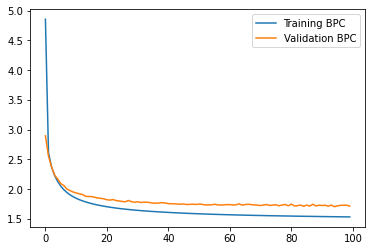

In [ ]:
model.train_plot(train_log, 'Training BPC', 'Validation BPC')

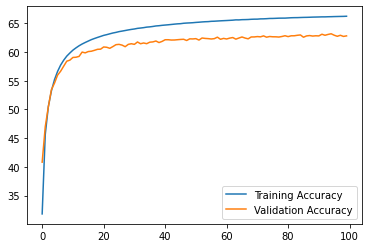

In [ ]:
model.train_plot(train_log, 'Training Accuracy', 'Validation Accuracy')